# Visualizing Dirichlet Distributions with Matplotlib

This post describes how I went about visualizing probability density functions
of 3-dimensional Dirichlet distributions with [matplotlib](http://matplotlib.org).
If you're already familiar with the Dirichlet distribution, you might want to skip
the next section.

## Rolling Dice
To understand what the Dirichlet distribution describes, it is useful to
consider how it can characterize the variability of a random
[multinomial distribution](http://en.wikipedia.org/wiki/Multinomial_distribution).
Suppose we are going to manufacture 6-sided dice. But for this
example, we only want the allowable outcome of a die roll to be the number 1,
2, or 3. So when we produce a die, we will place the number 1 on two of the
faces and likewise for the numbers 2 and 3. If we produce a "fair" die, then
the probabilites of the three outcomes will be equal (the probability for each
outcome will 1/3). We can represent the probabilities for the possible outcomes
as a vector ($\boldsymbol{\theta}$):

$$\boldsymbol{\theta} = \left( \frac{1}{3}, \frac{1}{3}, \frac{1}{3} \right)$$

If we wanted to cheat, we could produce a "loaded" die, that gives us a higher
probability of rolling a 3:

$$\boldsymbol{\theta} = \left( \frac{0.9}{3}, \frac{1}{3}, \frac{1.1}{3} \right)$$

Regardless of whether we produce a fair or loaded die, $\boldsymbol{\theta}$ has
two imporant properties. First, the sum of probabilities for each outcome must
equal 1:

$$\sum_{i} \boldsymbol{\theta}_{i} = \boldsymbol{\theta}_{1} + \boldsymbol{\theta}_{2} + \boldsymbol{\theta}_{3} = 1$$

The second property is that none of the probabilities can be negative. When these
conditions hold, probabilities associated with the results of rolling the die
are described by a multinomial distribution.

Regardless of whether we are attempting to produce fair or loaded dice, there
will be some variability in the characteristics of the dice we produce. So
even if we try to produce fair dice, we won't expect that the probabilities
of each outcome for a particular die will be exactly 1/3. If we were to hand-carve
each die from a wooden block, we would expect significant variability in the dice
we produce, due to the limitations of our craftsmanship, variability in the
density of the wood, characteristics of the tools we use, etc. If instead, we
were to use a fancy 3D printer to manufacture our dice, we would expect the
resulting dice to be much more precise, having significantly less variability
than our hand-carved dice.

To characterize this variability mathematically, we would like to know the
probability (probability density) of every possible value of $\boldsymbol{\theta}$
for a given manufacturing process. To do this, let's consider each element of
$\boldsymbol{\theta}$ as being an independent variable. That is, for
$\boldsymbol{\theta} = \lbrace \theta_{1} , \theta_{2} , \theta_{3} \rbrace$, we
can treat $\theta_{1}$, $\theta_{2}$, and $\theta_{3}$ each as an independent
variable and $\boldsymbol{\theta}$ as a vector in a 3-dimensional space.
Since the multinomial distribution requires that these three variables sum to 1,
we know that the allowable values of $\boldsymbol{\theta}$ are confined to a
plane. Furthermore, since each value $\theta_{i}$ must be greater than or equal
to zero, the set of all allowable values of $\boldsymbol{\theta}$ is confined to
an equilateral triangle (a [2-simplex](http://en.wikipedia.org/wiki/Simplex))
as shown below.

<center><img src="/downloads/notebooks/images/simplex2.svg" /></center>

What we want is to know the probability density at each point on this triangle.
That is where the Dirichlet distribution can help us. The Dirichlet
distribution defines a probability density for a vector-valued input having the same
characteristics as our multinomial parameter ($\boldsymbol{\theta}$). Let's start
with the formula for the probability density associated with a Dirichlet
distribution:

$$\text{Dir}\left(\boldsymbol{\alpha}\right)\rightarrow \mathrm{p}\left(\boldsymbol{\theta}\mid\boldsymbol{\alpha}\right)=\frac{\Gamma\left(\sum_{i=1}^{k}\boldsymbol{\alpha}_{i}\right)}{\prod_{i=1}^{k}\Gamma\left(\boldsymbol{\alpha}_{i}\right)}\prod_{i=1}^{k}\boldsymbol{\theta}_{i}^{\boldsymbol{\alpha}_{i}-1}$$

It's not important to understand the the formula in its entirety but a few
details are worth noting.
The Dirichlet distribution is parameterized by the vector $\boldsymbol{\alpha}$,
which has the same number of elements ($k$) as our multinomial parameter
$\boldsymbol{\theta}$. In our case, $k=3$. So you can interpret
$\mathrm{p}\left(\boldsymbol{\theta}\mid\boldsymbol{\alpha}\right)$ as 
answering the question "what is the probability density associated with
multinomial distribution $\boldsymbol{\theta}$, given that our Dirichlet
distribution has parameter $\boldsymbol{\alpha}$." Our goal is to visualize how
$\text{Dir}\left(\boldsymbol{\alpha}\right)$ varies over the simplex of allowable
values of $\boldsymbol{\theta}$ for a given value of $\boldsymbol{\alpha}$.

## Setting up the Code

Before we can plot our Dirichlet distributions, we need to do three things:

1. Generate a set of Cartesian coordinates over our equilateral triangle

2. Map the Cartesian coordinates to the 2-simplex coordinate space

3. Compute $\text{Dir}\left(\boldsymbol{\alpha}\right)$ for each point

There are numerous ways we could go about generating a set of points over the
simplex. For example, we could randomly sample a uniform Dirichlet and map those
points back to the Cartesian space. But that approach can result in undesirable
display artifacts near the simplex boundaries for small values of
$\boldsymbol{\alpha}$. As of version 1.3, matplotlib provides some
convenient functions we can use for generating and refining triangular meshes.
Let's start with the corners of our equilateral triangle and define a triangular
mesh consisting of just a single element.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

Next, we'll subdivide the triangle into a triangular mesh and plot the original
and subdivided triangles.

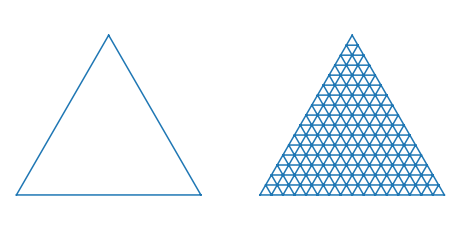

In [2]:
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')


The mesh above is just an example - we'll use a much finer mesh for our plots.

Next, we need to map the `x-y` coordinates of the mesh vertices to the
simplex coordinate space
(a.k.a. [barycentric coordinates](http://en.wikipedia.org/wiki/Barycentric_coordinate_system)).
There are several ways to perform this transform. For each corner of the
triangle, the associated barycentric coordinate component for a point `(x, y`)
is equal to the fraction of the triangle covered by a new triangle created
by replacing the corner with `(x, y)`. For some values of $\boldsymbol{\alpha}$,
calculation of the Dirichlet pdf can become numerically unstable at the
boundaries of the simplex so our conversion function will take an optional
tolerance that will avoid barycentric coordinate values directly on the simplex
boundary.

In [3]:
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

Having the barycentric coordinates for our simplex mesh vertices, we then need
to compute the Dirichlet pdf values for these coordinates.

In [4]:
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

And lastly, we just need a function to draw the contours for a distribution.
The function will draw pdf contours for a Dirichlet distribution where
$\theta_{1}$, $\theta_{2}$, and $\theta_{3}$ correspond to the lower left,
lower right, and upper corners of the rendered triangle, respectively.

In [5]:
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

## Output

Let's start with a few symmetric Dirichlet distributions. The case of
$\boldsymbol{\alpha} = (1, 1, 1)$ yields a uniform distribution, where all
points on the simplex are equally probable:

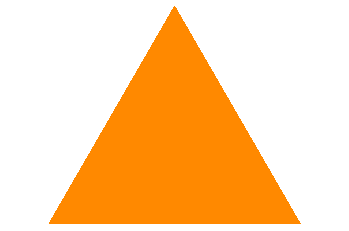

In [6]:
draw_pdf_contours(Dirichlet([1, 1, 1]))

For values of $\alpha_{i} < 1$, the distribution concentrates in the corners
and along the boundaries of the simplex.

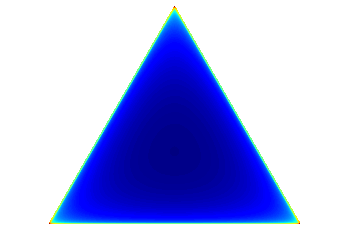

In [7]:
draw_pdf_contours(Dirichlet([0.999, 0.999, 0.999]))

The color scale runs from dark blue (lowest values) to red (highest values).
Notice in the plot above that only the corners of the simplex are red and
intermediate values lie along the boundary of the simplex.

For values of $\alpha_{i} > 1$, the distribution tends toward the center of the
simplex.

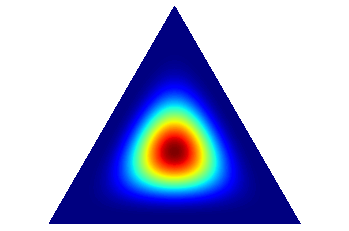

In [8]:
draw_pdf_contours(Dirichlet([5, 5, 5]))

As $\alpha_{i}$ increases, the distribution becomes more tightly concentrated
around the center of the simplex.

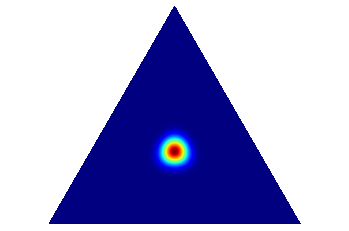

In [9]:
draw_pdf_contours(Dirichlet([50, 50, 50]))

In the context of our example of manufacturing dice, we would produce
consistently fair dice in the limit as $\alpha_{i} \rightarrow \infty$.

For a symmetric Dirichlet with $\alpha_{i} > 1$, we will produce fair dice, on
average. If the goal is to produce loaded dice (e.g., with a higher probability
of rolling a 3), we would want an asymmetric (noncentral) Dirichlet distribution
with a higher value for $\alpha_{3}$.

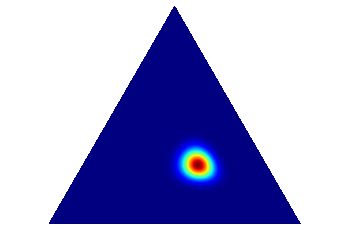

In [10]:
draw_pdf_contours(Dirichlet([30, 30, 50]))

Finally, here are a couple more, just to show how the distributions vary with
$\boldsymbol{\alpha}$.

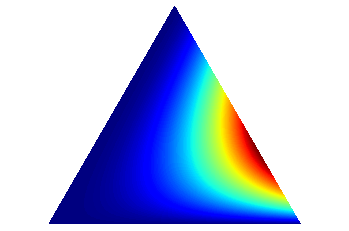

In [11]:
draw_pdf_contours(Dirichlet([1, 2, 3]))

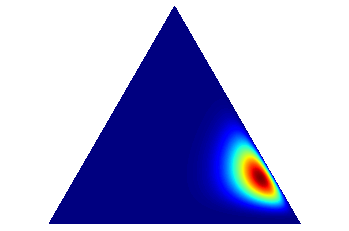

In [12]:
draw_pdf_contours(Dirichlet([2, 5, 15]))

If you would like to create these plots yourself, you can download a more
readily usable version of the code used [here](https://gist.github.com/tboggs/8778945).

As a final note, while I used the Dirichlet distribution as the prior for
the multinomial distribution, it is not the only prior distribution that could
be used. For example, the [logistic normal](http://en.wikipedia.org/wiki/Logit-normal_distribution)
distribution could also be used as a prior for multinomial distributions.

### [UPDATE 2020-04-18]

It came to my attention that the function `xy2bc` was incorrect, which resulted in varying inaccuracy over the simplex. While it didn't appear to make a difference for the tolerance used, I've updated this post with a corrected implmentation that uses fractional triangle areas to compute the barycentric coorinates. I also made some minor edits to account for python and matplotlib API changes since the original post.